In [139]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [140]:
# Setting hyperparameters
batch_size = 32
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
model_type = "RNN"
# model_type = "GRU"
# model_type = "LSTM"

In [141]:
df = pd.read_csv("data/ac_data_annotated.csv")

df.head()

,date_time,temperature,status
0,07:06.9,25.3750,1
1,12:07.5,25.3125,1
2,17:08.0,25.3125,1
3,22:08.6,25.1875,1
4,27:09.2,25.0625,1


In [174]:
df["status"].value_counts()

status
1    558
0    487
Name: count, dtype: int64

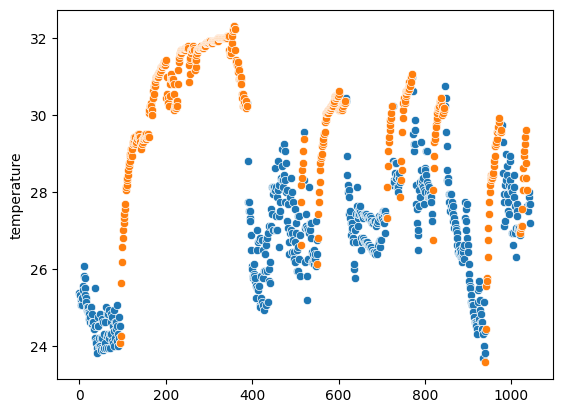

In [142]:
import seaborn as sns

sns.scatterplot(data=df["temperature"][df["status"] == 1])
sns.scatterplot(data=df["temperature"][df["status"] == 0])
plt.show()

In [143]:
window = 5  # You can adjust this value based on your requirements
sequences = []
labels = []

for i in range(len(df) - window):
    sequence = df.iloc[i:i+window]['temperature'].values
    label = df.iloc[i+window]['status']
    sequences.append(sequence)
    labels.append(label)

# Convert lists to NumPy arrays
sequences = np.array(sequences)
labels = np.array(labels)

In [144]:
sequences.shape, labels.shape

((1040, 5), (1040,))

In [145]:
# Generating dataset

class device_data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return torch.Tensor([self.X[index]]), torch.Tensor([self.y[index]])

In [146]:
# scaler = MinMaxScaler()
# scaler.fit(df["temperature"].to_numpy().reshape(-1, 1))
# data = scaler.transform(df["temperature"].to_numpy().reshape(-1, 1))

In [147]:
train = device_data(sequences[:800], labels[:800])
val = device_data(sequences[800:900], labels[800:900])
test = device_data(sequences[900:], labels[900:])

In [148]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [149]:
dataset_iter = iter(train_loader)
# dataset_iter = iter(val_loader)
# dataset_iter = iter(test_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([32, 1, 5]) torch.Size([32, 1])


In [150]:
class RNNForecasting(nn.Module):
    def __init__(self, model_type, seq_length, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.model = model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_shape, output_shape)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        if self.model == "RNN" or self.model == "GRU":
            # h = torch.zeros([self.num_layers, batch_size, self.hidden])
            h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            out, h = self.rnn(x, h)
        else:
            h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            c = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            out, _ = self.rnn(x, (h, c))
        
        out = self.linear(out[:, -1, :])

        return self.sig(out)

    def compute_l1(self, w):
        return torch.abs(w).sum()

    def compute_l2(self, w):
      return torch.square(w).sum()

In [151]:
# Test model,
input_shape = 1
output_shape = 1
test = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layer).cuda()
# (seq,btch,in_sh)
out = test(features.permute(0, 2, 1).cuda())
print(out.shape)

torch.Size([32, 1])


### RNN

In [152]:
input_shape = 1
output_shape = 1
model = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [153]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.8994038740113244 val:  0.823974920428182
Epoch:  1 train:  0.8492556622720411 val:  0.8177576588779615
Epoch:  2 train:  0.8453870024787233 val:  0.8109360182202864
Epoch:  3 train:  0.84266909274927 val:  0.8095181253912195
Epoch:  4 train:  0.8393766997682997 val:  0.8063246581530935
Epoch:  5 train:  0.8382727175488992 val:  0.8060981666664294
Epoch:  6 train:  0.8348695011154871 val:  0.8033416930696269
Epoch:  7 train:  0.833088320635116 val:  0.8026788682147523
Epoch:  8 train:  0.8301740681570337 val:  0.7997974377723932
Epoch:  9 train:  0.8288093359233598 val:  0.7976792290167679
Epoch:  10 train:  0.827511808708733 val:  0.7970172710198664
Epoch:  11 train:  0.8245576611905078 val:  0.7921010709485882
Epoch:  12 train:  0.8247287188626311 val:  0.7940930083448031
Epoch:  13 train:  0.8190117308460036 val:  0.7866662107347795
Epoch:  14 train:  0.8191473586315503 val:  0.7859768624430992
Epoch:  15 train:  0.8152862225264318 val:  0.7789848509895999
Epoch: 

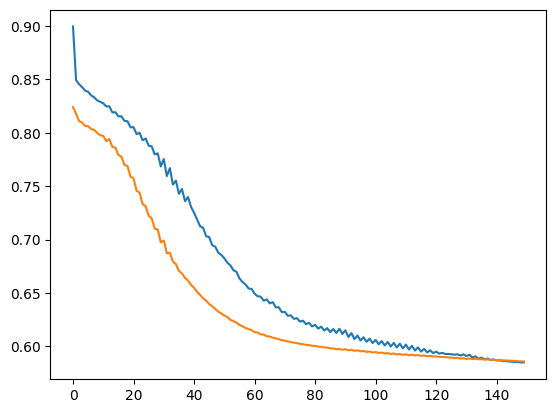

In [154]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.permute(0, 2, 1)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        l = criterion(y_pred, batch_y)

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_x = batch_x.permute(0, 2, 1)
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()    

In [155]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.permute(0, 2, 1)
        output = model(batch_x)
        # output = output.squeeze(1)
        # preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        # true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

In [156]:
preds.shape, true.shape

((140, 1), (140, 1))

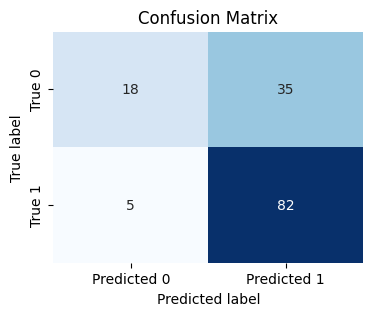

In [157]:
# Compute the confusion matrix
pred = preds > 0.5
cm = confusion_matrix(true, pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### GRU

In [158]:
# Setting hyperparameters
batch_size = 32
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
# model_type = "RNN"
model_type = "GRU"
# model_type = "LSTM"

In [159]:
input_shape = 1
output_shape = 1
model_gru = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [160]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.6404513860588307 val:  0.5830655793623808
Epoch:  1 train:  0.6354856319731613 val:  0.6000807648183386
Epoch:  2 train:  0.5632520758709748 val:  0.58359046536789
Epoch:  3 train:  0.5847782968818482 val:  0.587310618455306
Epoch:  4 train:  0.5778262430932339 val:  0.586506581961406
Epoch:  5 train:  0.5781805302396027 val:  0.5855675101381935
Epoch:  6 train:  0.5801734028542579 val:  0.5855061807672698
Epoch:  7 train:  0.5800121385438676 val:  0.5851221153580969
Epoch:  8 train:  0.5803226823688916 val:  0.5848662591139595
Epoch:  9 train:  0.5803451716516698 val:  0.5846124401264519
Epoch:  10 train:  0.5803309307165626 val:  0.584365008263667
Epoch:  11 train:  0.5802888655048029 val:  0.5841456896633915
Epoch:  12 train:  0.5801834190057259 val:  0.5838776823328072
Epoch:  13 train:  0.5801787816965173 val:  0.583596965163029
Epoch:  14 train:  0.5801697318315995 val:  0.5828633815450865
Epoch:  15 train:  0.5820944760691229 val:  0.5826732847629349
Epoch:  

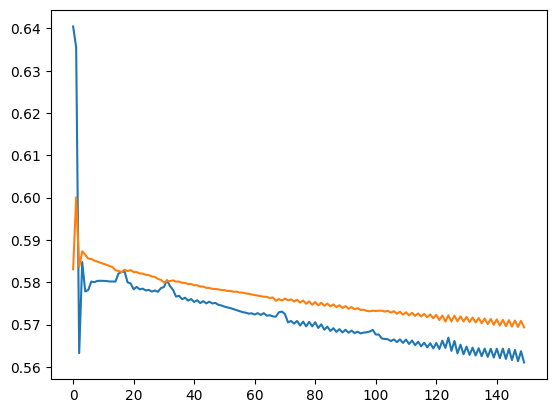

In [161]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.permute(0, 2, 1)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_x = batch_x.permute(0, 2, 1)
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()   

In [162]:
with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.permute(0, 2, 1)
        output = model(batch_x)
        # output = output.squeeze(1)
        # preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        # true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

In [163]:
true.shape, preds.shape

((140, 1), (140, 1))

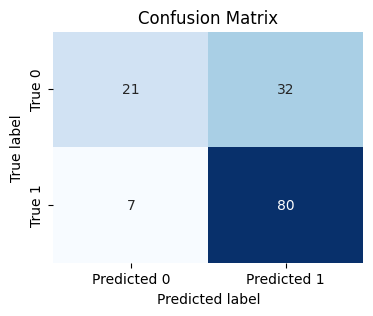

In [164]:
# Compute the confusion matrix
pred = preds > 0.5
cm = confusion_matrix(true, pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### LSTM

In [165]:
# Setting hyperparameters
batch_size = 32
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
# model_type = "RNN"
# model_type = "GRU"
model_type = "LSTM"

In [166]:
input_shape = 1
output_shape = 1
model_lstm = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [167]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.6160677918755391 val:  0.5650598495146136
Epoch:  1 train:  0.5978125710594506 val:  0.580638046528696
Epoch:  2 train:  0.5463865531055243 val:  0.569784374527468
Epoch:  3 train:  0.5595422880201971 val:  0.5710217557059468
Epoch:  4 train:  0.5590949380375979 val:  0.5707217966063252
Epoch:  5 train:  0.5596044024057882 val:  0.5703187665203131
Epoch:  6 train:  0.5604492818629961 val:  0.570199887379582
Epoch:  7 train:  0.5605807718800936 val:  0.5700467888551517
Epoch:  8 train:  0.5607467814276913 val:  0.5698945674929828
Epoch:  9 train:  0.5608631935884992 val:  0.5698228589248449
Epoch:  10 train:  0.5608837250007946 val:  0.5695395543627223
Epoch:  11 train:  0.5610887059019795 val:  0.5694823527963657
Epoch:  12 train:  0.5620025233321012 val:  0.5691399631221485
Epoch:  13 train:  0.5620154538929472 val:  0.5695751461072232
Epoch:  14 train:  0.5608808269667765 val:  0.5688951956731337
Epoch:  15 train:  0.5619081804831496 val:  0.5690725774150286
Epoch

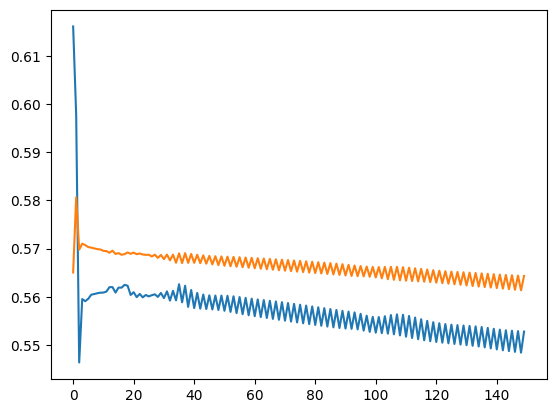

In [168]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.permute(0, 2, 1)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_x = batch_x.permute(0, 2, 1)
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()   

In [169]:
with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.permute(0, 2, 1)
        output = model(batch_x)
        # output = output.squeeze(1)
        # preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        # true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

In [170]:
true.shape, preds.shape

((140, 1), (140, 1))

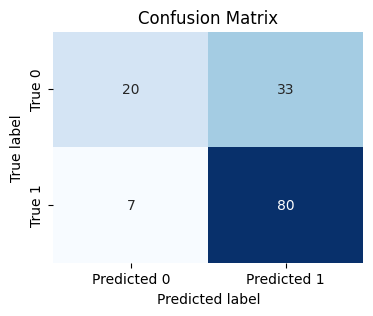

In [171]:
# Compute the confusion matrix
pred = preds > 0.5
cm = confusion_matrix(true, pred)

# Create a heatmap using Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### Saving config

In [172]:
# # Creating/updating config file with hyperparameters and model performance
# import os
# from pathlib import Path
# import json

# filepath = "config/config.json"
# filepath = Path(filepath)
# filedir, filename = os.path.split(filepath)

# dic = {
#     "model": model_type,
#     "batch_size": batch_size,
#     "epochs": epochs,
#     "learning_rate": learning_rate,
#     "hidden_shape": hidden_shape,
#     "num_layer": num_layer,
#     "l1": l1,
#     "l2": l2,
#     "lr_decay": lr_decay,
#     "MAE": str(mae),
#     "MSE": str(mse),
#     "window_size": str(window),
#     "horizon": str(horizon)
# }

# # Serializing json
# json_object = json.dumps(dic, indent=4)

# try:
#     with open(filepath, "r") as file:
#         existing_data = json.load(file)
#         existing_data.append(json_object)
#         with open(filepath, "w") as file:
#             json.dump(existing_data, file, indent=None)
#         print("New configuration for the model added")
# except FileNotFoundError:
#     if filedir != "":
#         os.makedirs(filedir, exist_ok=True)
#         print(f"Creating directory:{filedir} for the file {filename}")

#     existing_data = []
#     existing_data.append(json_object)
#     with open(filepath, "w") as file:
#         json.dump(existing_data, file, indent=None)

#     print("New config file is created with first configuration for the model")
        